In [1]:
#Basic data cleaning module
import pandas as pd
import matplotlib.pyplot as plt
from numerize import numerize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

#feature engineering module
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

#Defining models for prediction
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [2]:
#Fetching data
df = pd.read_csv(r'D:\VS code files\upwork_work\Leed_Prediction\leed_predictor_end_end\data\PublicLEEDProjectsDirectory.csv',encoding='latin1',low_memory=False)

#data head
df.head()

,ID,Isconfidential,ProjectName,Street,City,State,Zipcode,Country,LEEDSystemVersionDisplayName,PointsAchieved,CertLevel,CertDate,IsCertified,OwnerTypes,GrossFloorArea,UnitOfMeasurement,TotalPropArea,ProjectTypes,OwnerOrganization,RegistrationDate
0,10000000,No,PNC Firstside Center,500 First Avenue,Pittsburgh,PA,15219,US,LEED-NC 2.0,33,Silver,2000-10-01 00:00:00,Yes,Profit Org.,647000.0,Sq ft,202923.0,Commercial Office,L.D. Astorino Companies,2000-03-31 00:00:00
1,10000001,Yes,Confidential,Confidential,Confidential,IN,Confidential,US,LEED-NC 2.0,NaN,NaN,NaN,No,Confidential,291000.0,Sq ft,130637.0,Confidential,Confidential,2000-06-01 00:00:00
2,10000002,No,Bethel Commercial Center,53 W. Jackson,Chicago,IL,60604,US,LEED-NC 2.0,45,Gold,2007-11-05 00:00:00,Yes,Non-Profit Org.,22592.0,Sq ft,27500.0,"Commercial Office, Restaurant, Retail, Daycare...",Bethel New Life,2001-08-01 00:00:00
3,10000003,Yes,Confidential,Confidential,Confidential,NY,Confidential,US,LEED-NC 2.1,NaN,NaN,NaN,No,Confidential,190000.0,Sq ft,NaN,Confidential,Confidential,2006-09-19 00:00:00
4,10000004,No,The Chicago Center for Green Technology,445 N. Sacramento Avenue,Chicago,IL,60612,US,LEED-NC 1.0 Pilot,38,Platinum,2003-06-17 00:00:00,Yes,Local Government,28356.0,Sq ft,28356.0,"Industrial, Commercial Office",City of Chicago Department of the Enviro,2000-06-01 00:00:00


In [3]:
#As it seem kind to data selection, this can be on business case senario so not gonna touch it leaving as it is.

#Locking data which has certified verified
df = df.loc[(df['IsCertified'] == 'Yes')]

###only added this part in this block as mentioned in README file to have this both conditions applied when selecting data
df = df.loc[(df['Isconfidential'] == 'No')]


#Extracting year data from date column
df['RegistrationYear'] = pd.to_datetime(df['RegistrationDate'])
#Then converting it to dateformat
df['year'] = pd.DatetimeIndex(df['RegistrationYear']).year

#Extracting data which is above 2015
df = df.loc[(df['year'] >= 2015)]

#Locking data which specific country name
df = df.loc[
            
            (df['Country'] == 'IN') |
            (df['Country'] == 'BD') |
            (df['Country'] == 'CN') |
            (df['Country'] == 'SG') |
            (df['Country'] == 'MY') |
            (df['Country'] == 'ID') |
            (df['Country'] == 'JP') |
            (df['Country'] == 'LA') |
            (df['Country'] == 'KR') |
            (df['Country'] == 'VN')
            
            ]

In [4]:
#Columns to be removed as mentioned in README file
df.drop(['ID','State','Zipcode','OwnerOrganization'],inplace=True,axis=1)

In [5]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6843 entries, 53744 to 190725
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Isconfidential                6843 non-null   object        
 1   ProjectName                   6843 non-null   object        
 2   Street                        6843 non-null   object        
 3   City                          6843 non-null   object        
 4   Country                       6843 non-null   object        
 5   LEEDSystemVersionDisplayName  6843 non-null   object        
 6   PointsAchieved                6843 non-null   object        
 7   CertLevel                     6843 non-null   object        
 8   CertDate                      6843 non-null   object        
 9   IsCertified                   6843 non-null   object        
 10  OwnerTypes                    6243 non-null   object        
 11  GrossFloorArea               

#### Key insights
- column "PointsAchieved" should be in "int" format
- column "CertDate" should be in Datetime format.
- column "GrossFloorArea" should be in float
- column "RegistrationDate" should be in Datetime format
- column "RegistrationYear" should be in Datetime format
- column "year" should be in Datetime format
- column "TotalPropArea" has most percentage of null values (it is of no use)

In [6]:
#checking percentage of null values
# Count null values in each column
null_counts = df.isnull().sum()

# Total number of rows in the DataFrame
total_rows = len(df)

# Calculate null percentage for each column
null_percentage = (null_counts / total_rows) * 100

# Display null percentage for each column
print("Null Percentage for each column:")
print(null_percentage)

Null Percentage for each column:
Isconfidential                   0.000000
ProjectName                      0.000000
Street                           0.000000
City                             0.000000
Country                          0.000000
LEEDSystemVersionDisplayName     0.000000
PointsAchieved                   0.000000
CertLevel                        0.000000
CertDate                         0.000000
IsCertified                      0.000000
OwnerTypes                       8.768084
GrossFloorArea                   0.000000
UnitOfMeasurement                0.000000
TotalPropArea                   96.624288
ProjectTypes                     0.029227
RegistrationDate                 0.000000
RegistrationYear                 0.000000
year                             0.000000
dtype: float64


- column *TotalPropArea* has 96% of null values

In [7]:
#dropping
df.drop('TotalPropArea',inplace=True,axis=1)

In [8]:
#describe
df.describe()

,GrossFloorArea,RegistrationYear,year
count,6.843000e+03,6843,6843.000000
mean,1.035999e+05,2020-07-22 01:02:42.560280576,2020.047640
min,0.000000e+00,2015-01-05 00:00:00,2015.000000
25%,2.890000e+02,2018-12-05 00:00:00,2018.000000
50%,3.828000e+03,2021-05-07 00:00:00,2021.000000
75%,5.022223e+04,2022-07-20 00:00:00,2022.000000
max,1.375480e+07,2023-12-21 00:00:00,2023.000000
std,3.809610e+05,NaN,2.496079


In [9]:
#describing with object
df.describe(include='object')

,Isconfidential,ProjectName,Street,City,Country,LEEDSystemVersionDisplayName,PointsAchieved,CertLevel,CertDate,IsCertified,OwnerTypes,UnitOfMeasurement,ProjectTypes,RegistrationDate
count,6843,6843,6843,6843,6843,6843,6843,6843,6843,6843,6243,6843,6841,6843
unique,1,6794,6009,913,9,47,71,5,1804,1,38,2,66,1698
top,No,PricewaterhouseCoopers,123,Shanghai,CN,LEED v4 ID+C: Retail,51,Gold,2023-05-31 00:00:00,Yes,Corporate: Privately Held,Sq m,Retail: Fast Food,2023-04-11 00:00:00
freq,6843,10,34,789,4891,2899,324,2596,188,6843,3726,5045,2540,160


In [10]:
#Define function to convert column datatype
def convert_date_time(df, columnname):
    
    #Define variable how they should work
    df[columnname] = pd.to_datetime(df[columnname], errors='coerce')
    return df

#Save datatype in dataframe
df = convert_date_time(df,'RegistrationDate')
#converted both datetime format
df = convert_date_time(df,'CertDate')

In [11]:
#Define function to convert column datatype
def convert_to_int(df, columnname):
    
    #Define variable how they should work
    df[columnname] = df[columnname].astype('float64')
    return df

#Save datatype in dataframe
df= convert_to_int(df,'PointsAchieved')

In [12]:
#There is no use use of this column has we are having already plenty of column for date
df.drop('RegistrationYear',inplace=True,axis=1)

### Making function for plotting count plot

In [13]:
def plot_top_projects(dataframe, columname,figsize=(20, 10), top_n=20):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Countplot
    sns.countplot(data=dataframe, x=columname, ax=ax, order=dataframe[columname].value_counts().iloc[:top_n].index)
    
    # Annotate each bar with its count
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(text=f"{numerize.numerize(height)}", 
                    xy=(rect.get_x() + rect.get_width() / 2, height), 
                    xytext=(0, 3), 
                    textcoords="offset points", 
                    ha="center", 
                    va="bottom", 
                    color="black")
    
    # Title and rotation
    ax.set_title(columname, fontsize=10, fontweight="bold", color="darkred")
    plt.xticks(rotation=90)
    
    # Show plot
    plt.show()

### Project Name

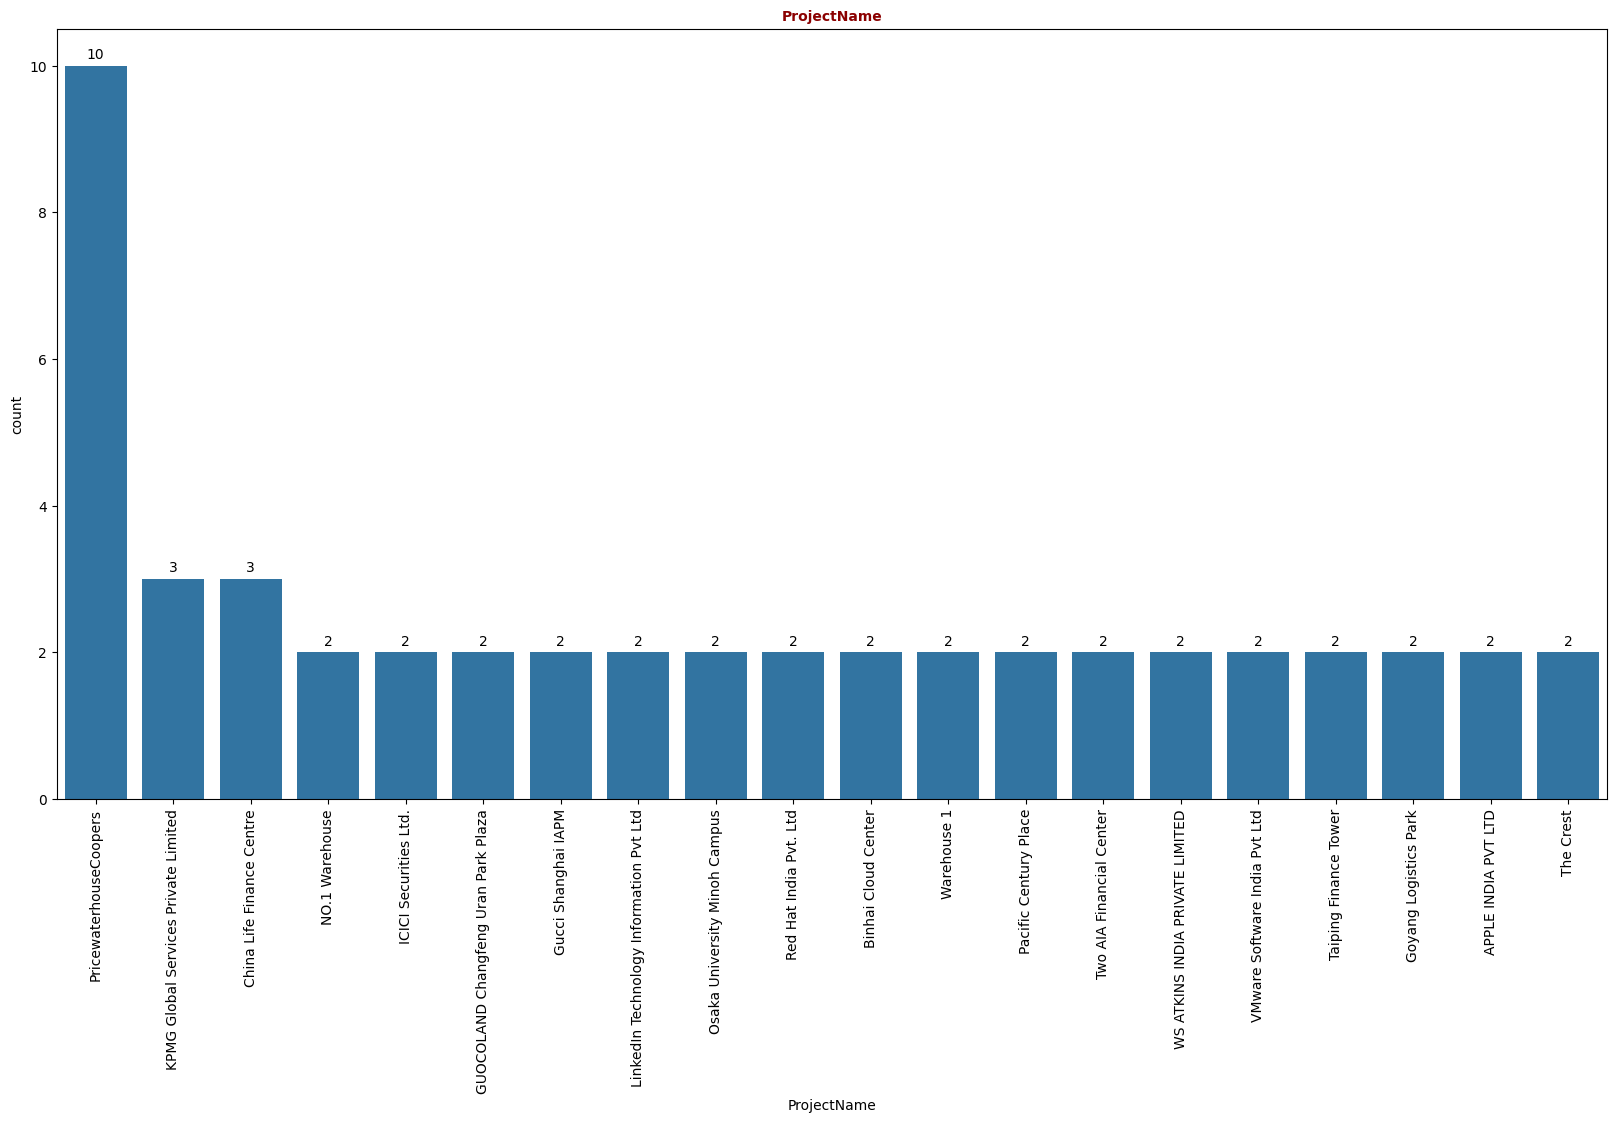

In [14]:
plot_top_projects(df,'ProjectName')

### City

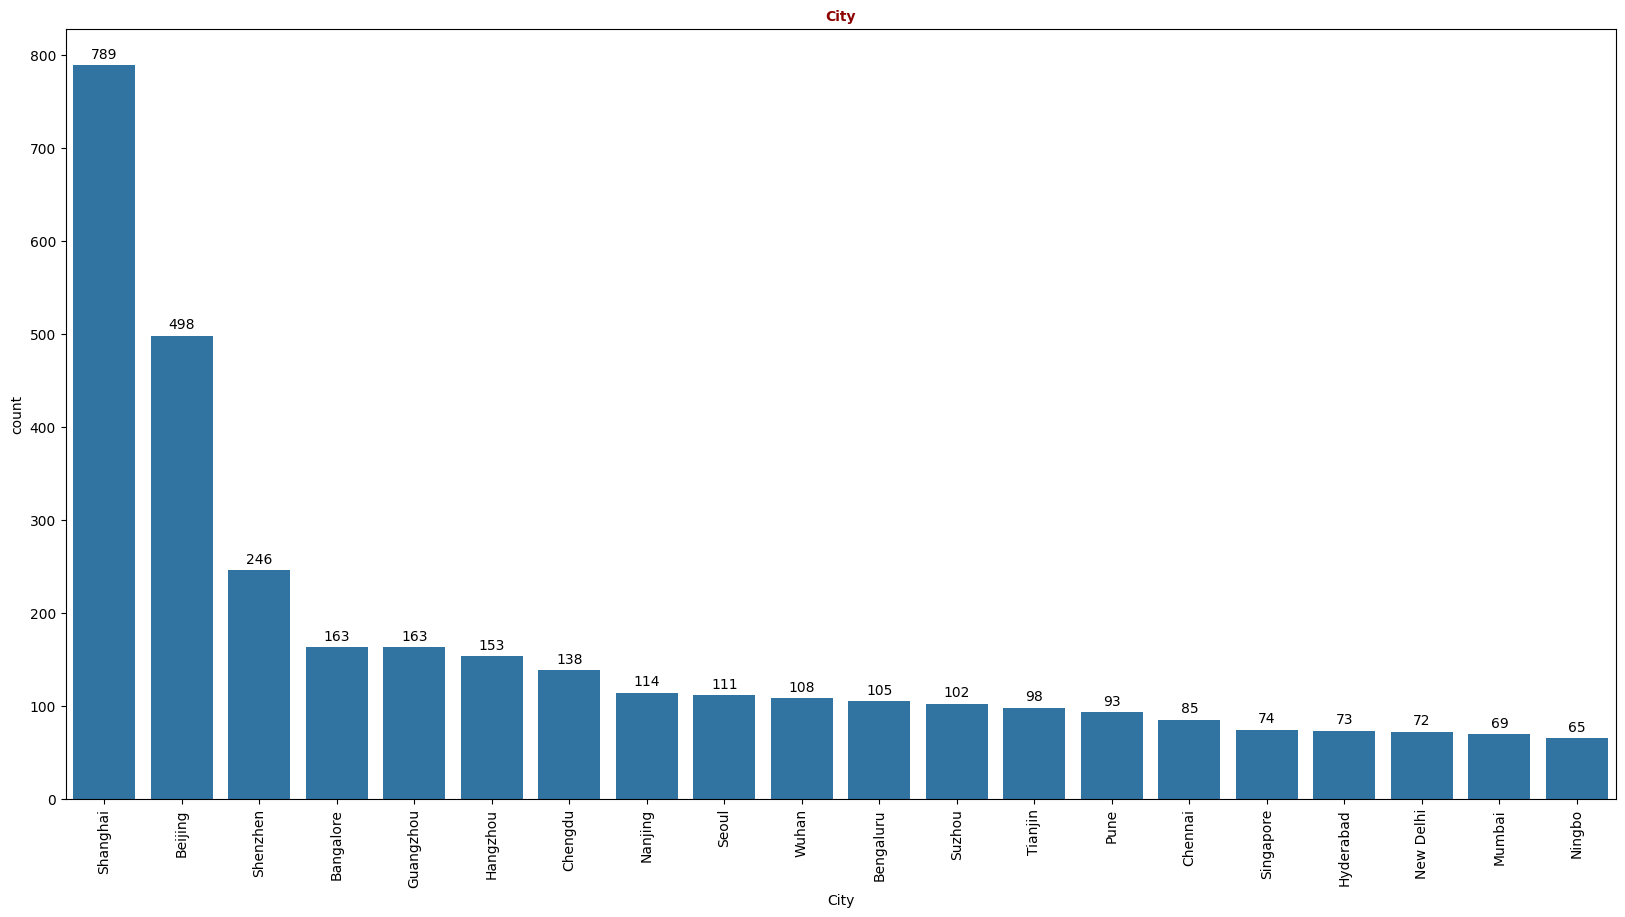

In [15]:
plot_top_projects(df,'City')

### Country

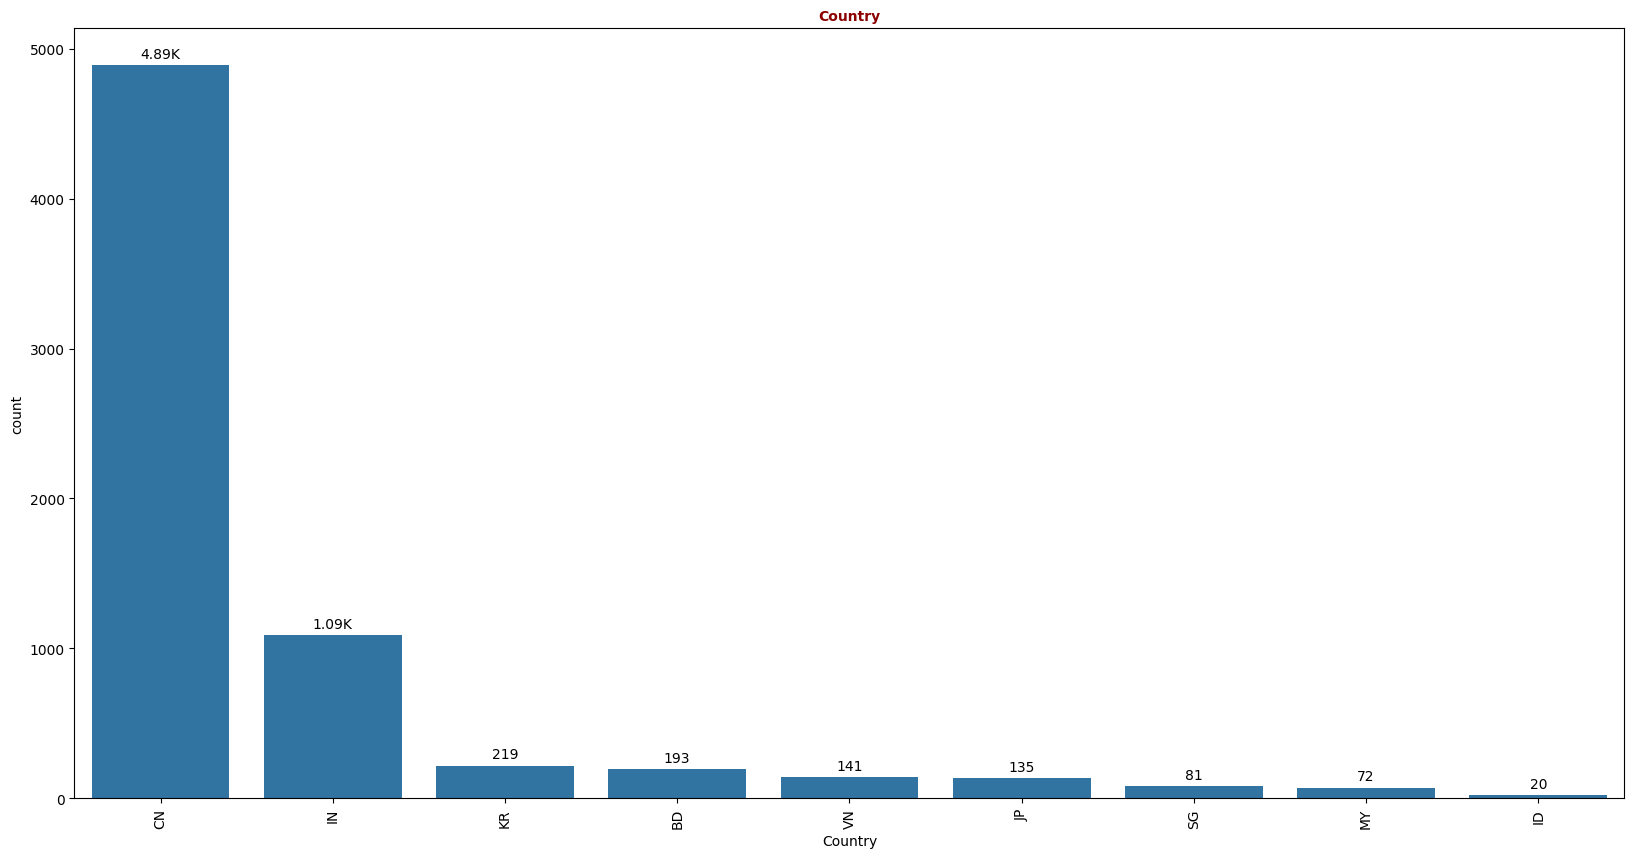

In [16]:
plot_top_projects(df,'Country')

### LEEDSystemVersionDisplayName

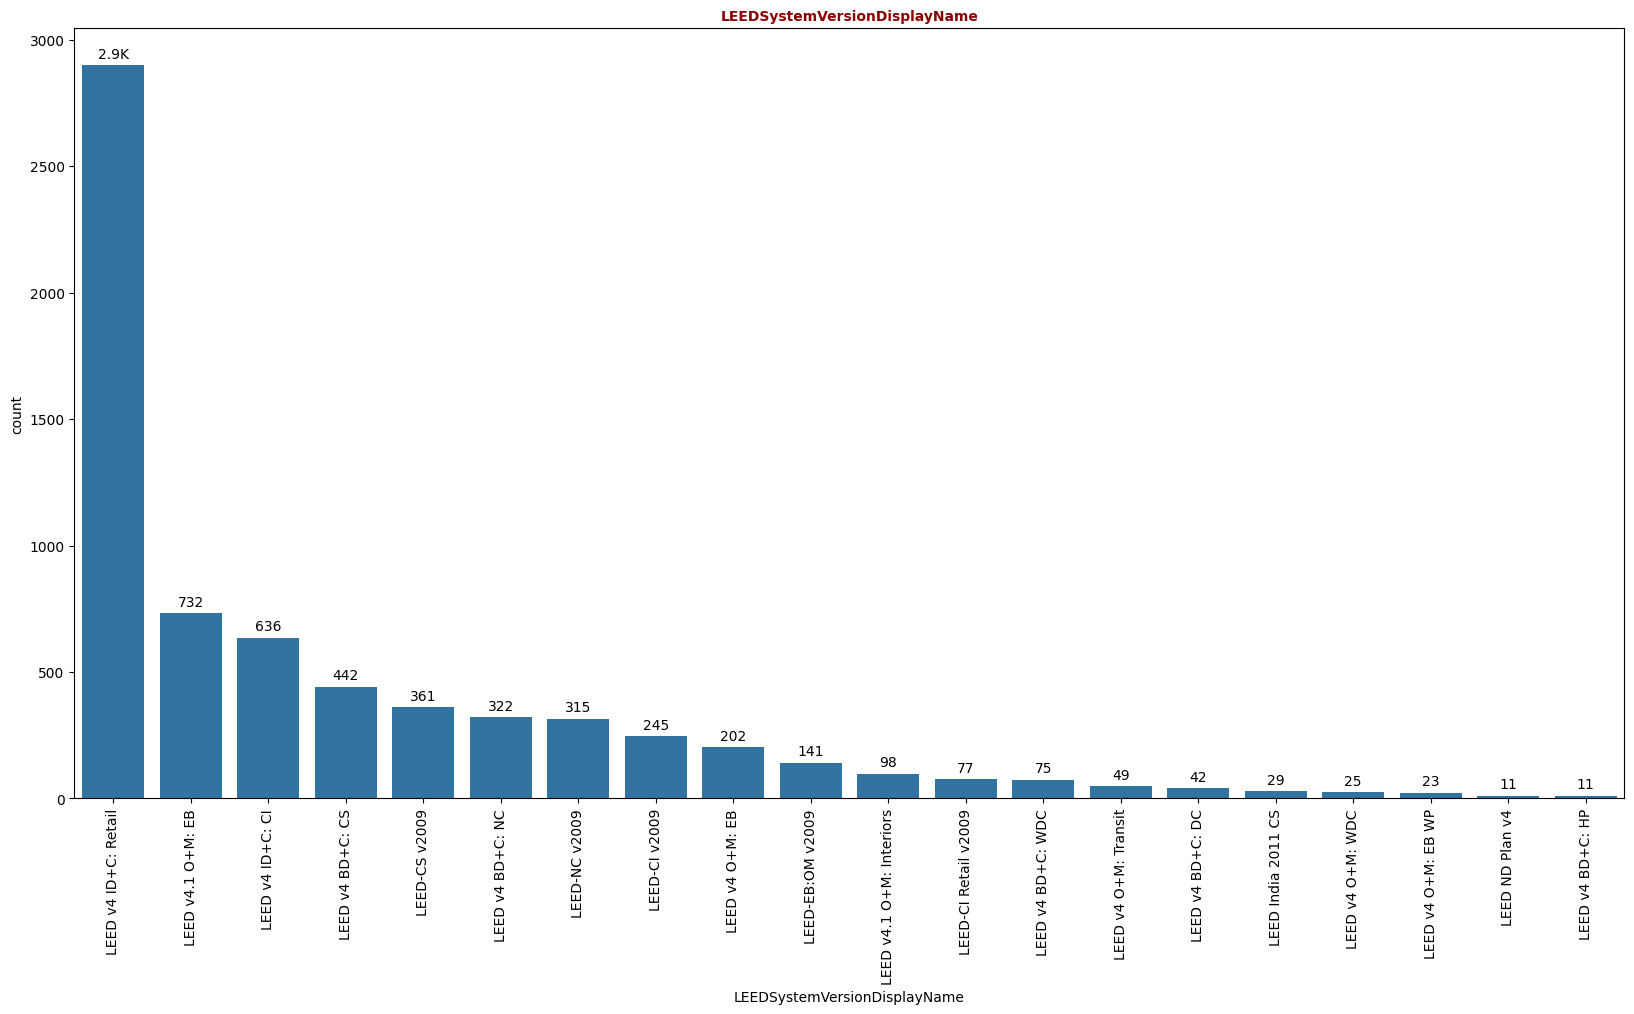

In [17]:
plot_top_projects(df,'LEEDSystemVersionDisplayName')

### ProjectTypes

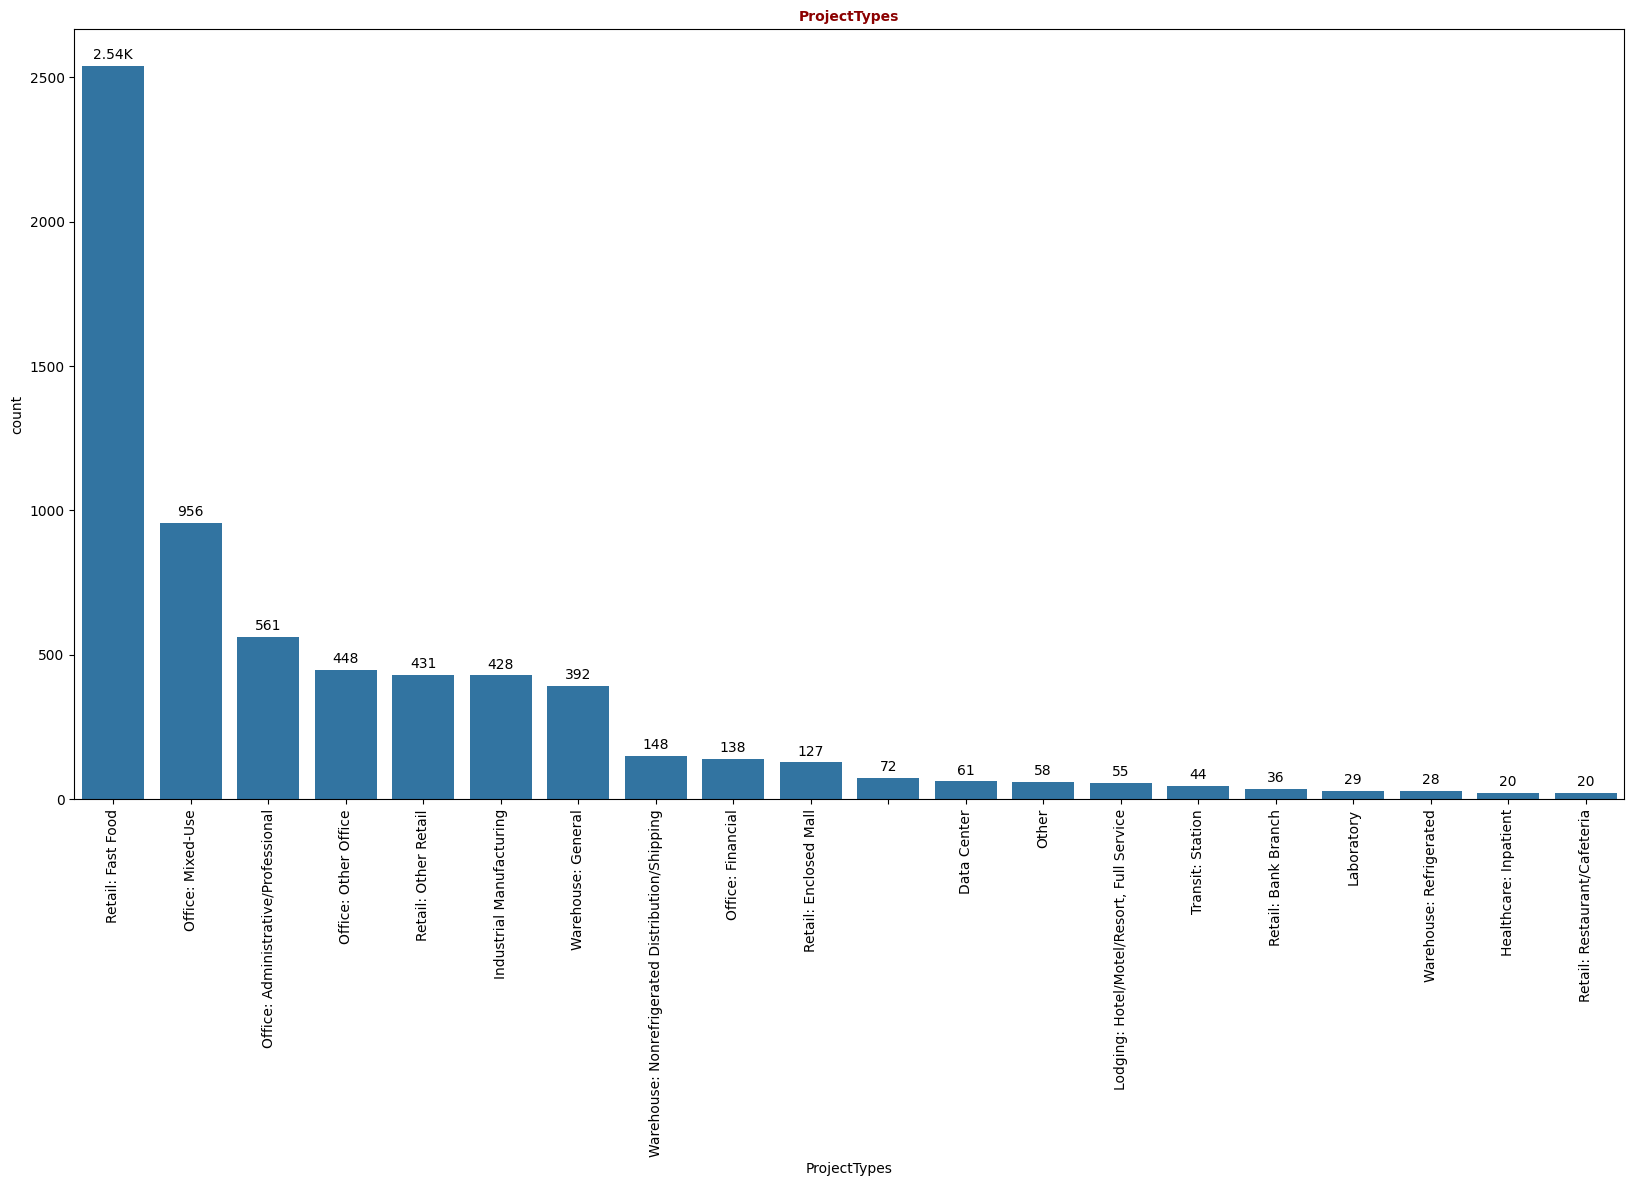

In [18]:
plot_top_projects(df,'ProjectTypes')

In [19]:
# #Applt Label encoder

# le = LabelEncoder()
# df['CertLevel'] = le.fit_transform(df['CertLevel'])
# df['IsCertified'] = le.fit_transform(df['IsCertified'])
# df['Isconfidential'] = le.fit_transform(df['Isconfidential'])
# df['UnitOfMeasurement'] = le.fit_transform(df['UnitOfMeasurement'])
# df.head()

In [20]:
# #printing unique columns value count to know which FE method should we apply on each one of them.
# unique = df.nunique()
# print(unique)

In [21]:
# # Define the target encoding function
# def target_encode(df, target_column, columns_to_encode):
#     encoder = TargetEncoder(cols=columns_to_encode)
#     df_encoded = df.copy()
#     df_encoded[columns_to_encode] = encoder.fit_transform(df[columns_to_encode], df[target_column])
#     return df_encoded

# #columns to encode
# columns_to_encode = ['City', 'ProjectName']

# #what if your target column
# target_column = 'CertLevel'

# # Apply target encoding
# df_encoded = target_encode(df, target_column, columns_to_encode)

# #One hot encoding for multiple columns
# df_encoded = pd.get_dummies(df_encoded, columns=['Country','LEEDSystemVersionDisplayName','ProjectTypes','OwnerTypes'],dtype=int)

# #fill NA with 0 as model will through error if we pass null values in model
# df_encoded.fillna(0,inplace=True)

# #Drop unwanted features
# df_encoded.drop(['Street','CertDate','RegistrationDate','year'],axis=1,inplace=True)

# # Print the result
# df_encoded.head()

In [22]:
df['ProjectName'].nunique()

6794

In [23]:
# #Applt Label encoder

# le = LabelEncoder()
# df['CertLevel'] = le.fit_transform(df['CertLevel'])
# df['IsCertified'] = le.fit_transform(df['IsCertified'])
# df['Isconfidential'] = le.fit_transform(df['Isconfidential'])
# df['UnitOfMeasurement'] = le.fit_transform(df['UnitOfMeasurement'])


# # Define the target encoding function
# def target_encode(df, target_column, columns_to_encode):
#     encoder = TargetEncoder(cols=columns_to_encode)
#     df_encoded = df.copy()
#     df_encoded[columns_to_encode] = encoder.fit_transform(df[columns_to_encode], df[target_column])
#     return df_encoded

# #columns to encode
# columns_to_encode = ['City', 'ProjectName']

# #what if your target column
# target_column = 'CertLevel'

# # Apply target encoding
# df_encoded = target_encode(df, target_column, columns_to_encode)

# #One hot encoding for multiple columns
# df_encoded = pd.get_dummies(df_encoded, columns=['Country','LEEDSystemVersionDisplayName','ProjectTypes','OwnerTypes'],dtype=int)

# #fill NA with 0 as model will through error if we pass null values in model
# df_encoded.fillna(0,inplace=True)

# #Drop unwanted features
# df_encoded.drop(['Street','CertDate','RegistrationDate','year'],axis=1,inplace=True)

# # # Print the result
# # df_encoded.head()

# # Define features and target variables
# X = df_encoded.drop(['PointsAchieved', 'CertLevel'], axis=1)
# y_points = df_encoded['PointsAchieved']
# y_cert = df_encoded['CertLevel']

# # Split data into training and testing sets
# X_train, X_test, y_points_train, y_points_test, y_cert_train, y_cert_test = train_test_split(
#     X, y_points, y_cert, test_size=0.2, random_state=42
# )

# # Define the columns you want to scale
# columns_to_scale = ['GrossFloorArea']

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Fit the scaler on the training data and transform the specified columns
# X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# # Transform the test data using the scaler fitted on the training data
# X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# # Apply SMOTE to the training data only for CertLevel prediction
# smote = SMOTE(k_neighbors=1, n_jobs=-1, sampling_strategy='auto', random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_cert_train)

# # Define the parameter grid for CertLevel prediction
# param_grid = {
#     'learning_rate': [0.1, 0.01],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     # Add other parameters you want to tune
# }
# print("------------------------------------------------------------------------------------------------------------------------------")
# print("XGBoost Model for classification and regression")

# # Create XGBoost classifier for CertLevel prediction
# xgb_model_cert = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

# # Perform grid search with cross-validation for CertLevel prediction
# grid_search_cert = GridSearchCV(estimator=xgb_model_cert, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
# grid_search_cert.fit(X_train_res, y_train_res)

# # Best parameters found for CertLevel prediction
# print("Best Parameters for CertLevel:", grid_search_cert.best_params_)

# # Best estimator for CertLevel prediction
# best_estimator_cert = grid_search_cert.best_estimator_

# # Evaluate the best estimator for CertLevel prediction on the test set
# accuracy_cert = best_estimator_cert.score(X_test, y_cert_test)
# print("Accuracy for CertLevel:", accuracy_cert)

# # Train XGBoost regressor for PointsAchieved prediction
# xgb_model_points = xgb.XGBRegressor()

# # Fit XGBoost regressor for PointsAchieved prediction
# xgb_model_points.fit(X_train, y_points_train)

# # Predict PointsAchieved on the test set
# points_predictions = xgb_model_points.predict(X_test)

# # Evaluate PointsAchieved predictions
# mse = mean_squared_error(y_points_test, points_predictions)
# print(f'Mean Squared Error (PointsAchieved): {mse}')

# # Print accuracy of the training data for PointsAchieved prediction
# train_accuracy_points = xgb_model_points.score(X_train, y_points_train)
# print("Accuracy for PointsAchieved (Training Data):", train_accuracy_points)

# # Evaluate the accuracy of the test data for PointsAchieved prediction
# test_accuracy_points = xgb_model_points.score(X_test, y_points_test)
# print("Accuracy for PointsAchieved (Test Data):", test_accuracy_points)

# #making different segments for XGBoost and logistic
# print("-------------------------------------------------------------------------------------------------------------------------------")
# "print('Logistic_Regression)"

# # Train Logistic Regression model for CertLevel prediction
# logistic_model_cert = LogisticRegression(max_iter=1000)

# # Fit Logistic Regression model for CertLevel prediction
# logistic_model_cert.fit(X_train_res, y_train_res)

# # Evaluate Logistic Regression model for CertLevel prediction on the test set
# accuracy_cert_logistic = logistic_model_cert.score(X_test, y_cert_test)
# print("Accuracy for CertLevel (Logistic Regression):", accuracy_cert_logistic)

In [146]:
# Label Encoding for specific columns
le = LabelEncoder()
df['CertLevel'] = le.fit_transform(df['CertLevel'])
df['IsCertified'] = le.fit_transform(df['IsCertified'])
df['Isconfidential'] = le.fit_transform(df['Isconfidential'])
df['UnitOfMeasurement'] = le.fit_transform(df['UnitOfMeasurement'])

# Target Encoding for high-cardinality features
def target_encode(df, target_column, columns_to_encode):
    encoder = TargetEncoder(cols=columns_to_encode)
    df_encoded = df.copy()
    df_encoded[columns_to_encode] = encoder.fit_transform(df[columns_to_encode], df[target_column])
    return df_encoded

# Columns to encode
columns_to_encode = ['City', 'ProjectName']
target_column = 'CertLevel'


# Apply target encoding
df_encoded = target_encode(df, target_column, columns_to_encode)

# One-Hot Encoding for other categorical features
df_encoded = pd.get_dummies(df_encoded, columns=['Country', 'LEEDSystemVersionDisplayName', 'ProjectTypes', 'OwnerTypes'], dtype=int)

# Fill missing values with 0
df_encoded.fillna(0, inplace=True)

# Drop unwanted features
# Assuming 'Street', 'CertDate', 'RegistrationDate', 'year' are not in the sample data and are dropped previously
df_encoded.drop(['Street', 'CertDate', 'RegistrationDate', 'year'], axis=1, inplace=True)

# Define features and target variables
X = df_encoded.drop(['PointsAchieved', 'CertLevel'], axis=1)
y_points = df_encoded['PointsAchieved']
y_cert = df_encoded['CertLevel']

# Split data into training and testing sets
X_train, X_test, y_points_train, y_points_test, y_cert_train, y_cert_test = train_test_split(
    X, y_points, y_cert, test_size=0.2, random_state=42
)

# Scaling numerical features
scaler = StandardScaler()
columns_to_scale = ['GrossFloorArea']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# Apply SMOTE to the training data for CertLevel prediction
smote = SMOTE(k_neighbors=1, n_jobs=-1, sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_cert_train)

# Increased regularization parameters
# Define parameter grid for XGBoostRegressor
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    # Add other parameters you want to tune
}

# Create XGBoost classifier with increased regularization parameters
xgb_model_cert = xgb.XGBClassifier(objective='multi:softmax', num_class=4)

# Perform grid search with cross-validation
grid_search_cert = GridSearchCV(estimator=xgb_model_cert, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_cert.fit(X_train_res, y_train_res)

# Best parameters for CertLevel prediction
print("Best Parameters for CertLevel:", grid_search_cert.best_params_)

# Best estimator for CertLevel prediction
best_estimator_cert = grid_search_cert.best_estimator_

# Best parameters found for CertLevel prediction
print("Best Parameters for CertLevel:", grid_search_cert.best_params_)

# Evaluate the best estimator on the test set
accuracy_cert = best_estimator_cert.score(X_test, y_cert_test)
print("Accuracy for CertLevel:", accuracy_cert)

# XGBoost Regressor for PointsAchieved prediction
xgb_model_points = xgb.XGBRegressor()
xgb_model_points.fit(X_train, y_points_train)

# Predict and evaluate PointsAchieved
points_predictions = xgb_model_points.predict(X_test)
mse = mean_squared_error(y_points_test, points_predictions)
print(f'Mean Squared Error (PointsAchieved): {mse}')

train_accuracy_points = xgb_model_points.score(X_train, y_points_train)
print("Accuracy for PointsAchieved (Training Data):", train_accuracy_points)

test_accuracy_points = xgb_model_points.score(X_test, y_points_test)
print("Accuracy for PointsAchieved (Test Data):", test_accuracy_points)

# Logistic Regression for CertLevel prediction
logistic_model_cert = LogisticRegression(max_iter=1000)
logistic_model_cert.fit(X_train_res, y_train_res)

# Evaluate Logistic Regression model on the test set
accuracy_cert_logistic = logistic_model_cert.score(X_test, y_cert_test)
print("Accuracy for CertLevel (Logistic Regression):", accuracy_cert_logistic)


# print("----------------------------------------------------------------------------------------------------")

# print("ENSEMBLE METHOD")

# # Define base models
# base_models = [
#     ('xgb', best_estimator_cert),
#     ('logistic', logistic_model_cert)
# ]

# # Define the stacking model
# stacking_model = StackingClassifier(
#     estimators=base_models,
#     final_estimator=LogisticRegression(max_iter=1000),
#     cv=5
# )

# # Fit the stacking model
# stacking_model.fit(X_train_res, y_train_res)

# # Evaluate the stacking model on the test set
# accuracy_stacking = stacking_model.score(X_test, y_cert_test)
# print("Accuracy for CertLevel (Stacking):", accuracy_stacking)



# print("--------------------------------------------------------------------")
# print("Feature Selection: Use RFE")

# from sklearn.feature_selection import RFE

# # Define a Logistic Regression model for RFE
# rfe_model = LogisticRegression(max_iter=1000)

# # Apply RFE
# rfe = RFE(rfe_model, n_features_to_select=10)
# rfe = rfe.fit(X_train_res, y_train_res)

# # Transform the dataset to include only the selected features
# X_train_rfe = rfe.transform(X_train_res)
# X_test_rfe = rfe.transform(X_test)

# # Re-train the Logistic Regression model with selected features
# logistic_model_cert_rfe = LogisticRegression(max_iter=1000)
# logistic_model_cert_rfe.fit(X_train_rfe, y_train_res)

# # Evaluate the Logistic Regression model on the test set
# accuracy_cert_logistic_rfe = logistic_model_cert_rfe.score(X_test_rfe, y_cert_test)
# print("Accuracy for CertLevel (Logistic Regression with RFE):", accuracy_cert_logistic_rfe)

print("--------------------------------------------------------")
print("RANDOM FOREST")



# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create RandomForestClassifier
rf_model_cert = RandomForestClassifier(random_state=42)

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_cert, test_size=0.2, random_state=42)


# Perform GridSearchCV with increased regularization
grid_search_rf = GridSearchCV(estimator=rf_model_cert, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_res, y_train_res)

# Best parameters found for CertLevel prediction with increased regularization
print("Best Parameters for CertLevel (RandomForest with Increased Regularization):", grid_search_rf.best_params_)

# Best estimator for CertLevel prediction with increased regularization
best_estimator_rf = grid_search_rf.best_estimator_

# Evaluate the best estimator for CertLevel prediction with increased regularization on the test set
accuracy_cert_rf = best_estimator_rf.score(X_test, y_cert_test)
print("Accuracy for CertLevel (RandomForest with Increased Regularization):", accuracy_cert_rf)

# Evaluate the RandomForestClassifier model with increased regularization on the validation set
accuracy_cert_rf_val = best_estimator_rf.score(X_val, y_val)
print("Accuracy for CertLevel (RandomForest with Increased Regularization - Validation):", accuracy_cert_rf_val)




# Predict CertLevel labels on the test set
cert_predictions_rf = best_estimator_rf.predict(X_test)

# Generate classification report for CertLevel prediction
classification_report_rf = classification_report(y_cert_test, cert_predictions_rf)
print("Classification Report for CertLevel (RandomForest with Increased Regularization):\n", classification_report_rf)


# print("---------------------------------------")
# print("BAGGING CLASSIFIER")

# from sklearn.ensemble import BaggingClassifier

# # Create BaggingClassifier with RandomForestClassifier as the base model
# bagging_model_rf = BaggingClassifier(base_estimator=best_estimator_rf, n_estimators=50, random_state=42)

# # Fit the BaggingClassifier model with RandomForestClassifier
# bagging_model_rf.fit(X_train_res, y_train_res)

# # Evaluate the BaggingClassifier model with RandomForestClassifier on the test set
# accuracy_cert_bagging_rf = bagging_model_rf.score(X_test, y_cert_test)
# print("Accuracy for CertLevel (Bagging with RandomForest):", accuracy_cert_bagging_rf)


Best Parameters for CertLevel: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Parameters for CertLevel: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy for CertLevel: 1.0
Mean Squared Error (PointsAchieved): 10.267622503431044
Accuracy for PointsAchieved (Training Data): 0.972313146437356
Accuracy for PointsAchieved (Test Data): 0.9474129898694441
Accuracy for CertLevel (Logistic Regression): 0.95836376917458
--------------------------------------------------------
RANDOM FOREST
Best Parameters for CertLevel (RandomForest with Increased Regularization): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for CertLevel (RandomForest with Increased Regularization): 0.9934258582907232
Accuracy for CertLevel (RandomForest with Increased Regularization - Validation): 0.987582176771366
Classification Report for CertLevel (RandomForest with Increased Regularization):
               prec

In [137]:
#Confision matrix for XGBoost
# Predict CertLevel on the test set using the best estimator
y_cert_pred = best_estimator_cert.predict(X_test)

# Compute confusion matrix
conf_matrix_cert = confusion_matrix(y_cert_test, y_cert_pred)

# Print the confusion matrix
print("Confusion Matrix for CertLevel:")
print(conf_matrix_cert)

Confusion Matrix for CertLevel:
[[394   0   0   0   0]
 [  0   1   0   0   0]
 [  0   0 521   0   0]
 [  0   0   0 211   0]
 [  0   0   0   0 242]]


In [138]:
#Confusion matrix for logistic regression
# Predict CertLevel on the test set using the best estimator
y_cert_pred = logistic_model_cert.predict(X_test)

# Compute confusion matrix
conf_matrix_cert = confusion_matrix(y_cert_test, y_cert_pred)

# Print the confusion matrix
print("Confusion Matrix for CertLevel:")
print(conf_matrix_cert)

Confusion Matrix for CertLevel:
[[382   0  12   0   0]
 [  0   1   0   0   0]
 [  5   1 505  10   0]
 [  0   0  12 192   7]
 [  0   0   0  10 232]]


- There some key points
    - As we can see XGBoost is giving us 100% accuracy this can overfitted model if not it is performing very good, 
    to compare and check if it is overfitting or not i have also tried with logistic, logistic is giving us 95% accuracy

    -And XGBoostRegressor is performing very good on Predicted Score as it's MSE score is very low this means model is able to predict very accuratly. 

### END 
### Thank you